# Importance of decision tree hyperparameters on generalization

In this notebook, we will illustrate the importance of some key
hyperparameters on the decision tree; we will demonstrate their effects on
the classification and regression problems we saw previously.

First, we will load the classification and regression datasets.

In [1]:
import pandas as pd

data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"
data_clf = pd.read_csv("../datasets/penguins_classification.csv")

In [2]:
data_reg_columns = ["Flipper Length (mm)"]
target_reg_column = "Body Mass (g)"
data_reg = pd.read_csv("../datasets/penguins_regression.csv")

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

## Create helper functions

We will create some helper functions to plot the data samples as well as the
decision boundary for classification and the regression line for regression.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.plotting import DecisionBoundaryDisplay


def fit_and_plot_classification(model, data, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    if data[target_names].nunique() == 2:
        palette = ["tab:red", "tab:blue"]
    else:
        palette = ["tab:red", "tab:blue", "black"]
    DecisionBoundaryDisplay.from_estimator(
        model, data[feature_names], response_method="predict",
        cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(data=data, x=feature_names[0], y=feature_names[1],
                    hue=target_names, palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def fit_and_plot_regression(model, data, feature_names, target_names):
    model.fit(data[feature_names], data[target_names])
    data_test = pd.DataFrame(
        np.arange(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
        columns=data[feature_names].columns,
    )
    target_predicted = model.predict(data_test)

    sns.scatterplot(
        x=data.iloc[:, 0], y=data[target_names], color="black", alpha=0.5)
    plt.plot(data_test.iloc[:, 0], target_predicted, linewidth=4)

## Effect of the `max_depth` parameter

The hyperparameter `max_depth` controls the overall complexity of a decision
tree. This hyperparameter allows to get a trade-off between an under-fitted
and over-fitted decision tree. Let's build a shallow tree and then a deeper
tree, for both classification and regression, to understand the impact of the
parameter.

We can first set the `max_depth` parameter value to a very low value.

In [5]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

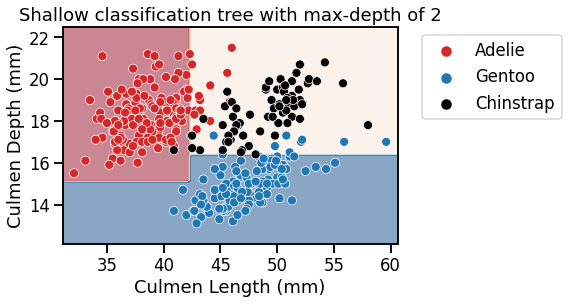

In [6]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Shallow classification tree with max-depth of {max_depth}")

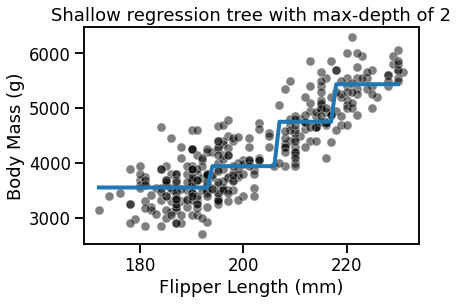

In [7]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column)
_ = plt.title(f"Shallow regression tree with max-depth of {max_depth}")

Now, let's increase the `max_depth` parameter value to check the difference
by observing the decision function.

In [14]:
max_depth = 30
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

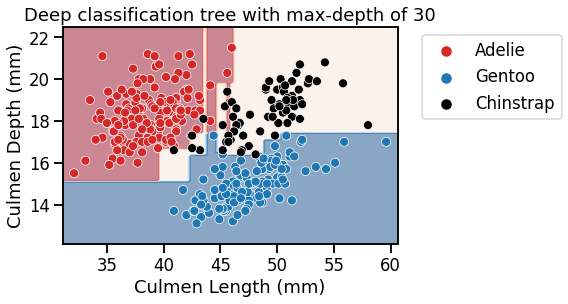

In [15]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Deep classification tree with max-depth of {max_depth}")

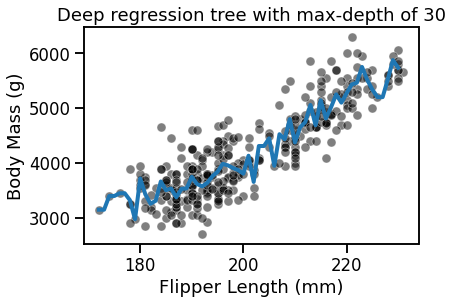

In [16]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column)
_ = plt.title(f"Deep regression tree with max-depth of {max_depth}")

For both classification and regression setting, we observe that
increasing the depth will make the tree model more expressive. However, a
tree that is too deep will overfit the training data, creating partitions
which are only correct for "outliers" (noisy samples). The `max_depth` is one
of the hyperparameters that one should optimize via cross-validation and
grid-search.

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": np.arange(2, 10, 1)}
tree_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid)
tree_reg = GridSearchCV(DecisionTreeRegressor(), param_grid=param_grid)

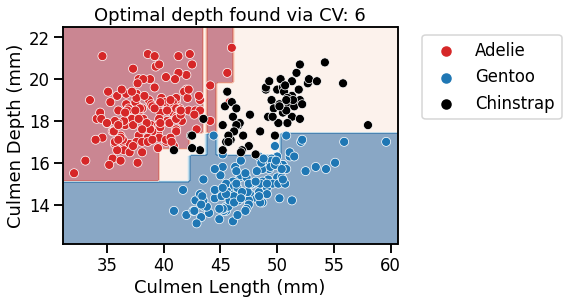

In [18]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Optimal depth found via CV: "
              f"{tree_clf.best_params_['max_depth']}")

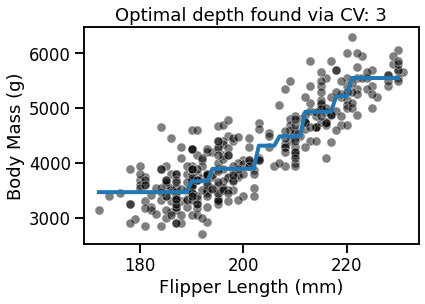

In [13]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column)
_ = plt.title(f"Optimal depth found via CV: "
              f"{tree_reg.best_params_['max_depth']}")

With this example, we see that there is not a single value that is optimal
for any dataset. Thus, this parameter is required to be optimized for each
application.

## Other hyperparameters in decision trees

The `max_depth` hyperparameter controls the overall complexity of the tree.
This parameter is adequate under the assumption that a tree is built
symmetrically. However, there is no guarantee that a tree will be symmetrical.
Indeed, optimal generalization performance could be reached by growing some of
the branches deeper than some others.

We will built a dataset where we will illustrate this asymmetry. We will
generate a dataset composed of 2 subsets: one subset where a clear separation
should be found by the tree and another subset where samples from both
classes will be mixed. It implies that a decision tree will need more splits
to classify properly samples from the second subset than from the first
subset.

In [19]:
from sklearn.datasets import make_blobs

data_clf_columns = ["Feature #0", "Feature #1"]
target_clf_column = "Class"

# Blobs that will be interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0)
# Blobs that will be easily separated
X_2, y_2 = make_blobs(
    n_samples=300, centers=[[3, 6], [7, 0]], random_state=0)

X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data_clf = np.concatenate([X, y[:, np.newaxis]], axis=1)
data_clf = pd.DataFrame(
    data_clf, columns=data_clf_columns + [target_clf_column])
data_clf[target_clf_column] = data_clf[target_clf_column].astype(np.int32)

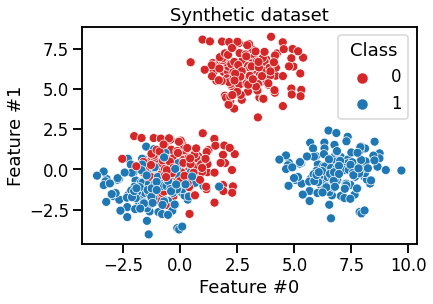

In [20]:
sns.scatterplot(data=data_clf, x=data_clf_columns[0], y=data_clf_columns[1],
                hue=target_clf_column, palette=["tab:red", "tab:blue"])
_ = plt.title("Synthetic dataset")

We will first train a shallow decision tree with `max_depth=2`. We would
expect this depth to be enough to separate the blobs that are easy to
separate.

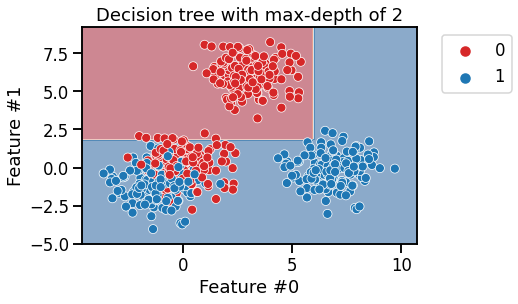

In [21]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

As expected, we see that the blue blob on the right and the red blob on the
top are easily separated. However, more splits will be required to better
split the blob were both blue and red data points are mixed.

Indeed, we see that red blob on the top and the blue blob on the right of
the plot are perfectly separated. However, the tree is still making mistakes
in the area where the blobs are mixed together. Let's check the tree
representation.

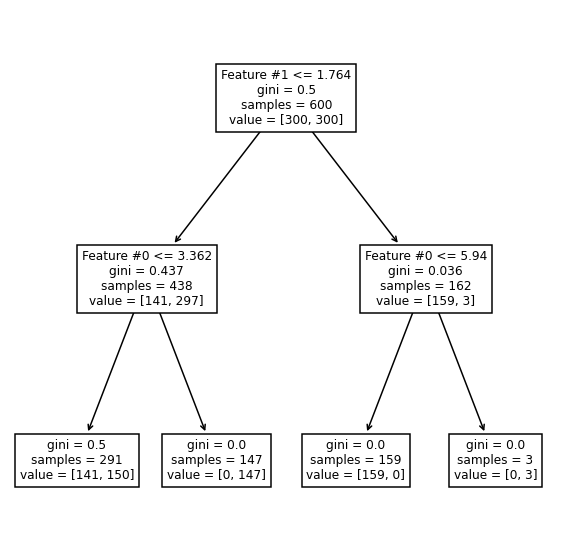

In [22]:
from sklearn.tree import plot_tree

_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

We see that the right branch achieves perfect classification. Now, we
increase the depth to check how the tree will grow.

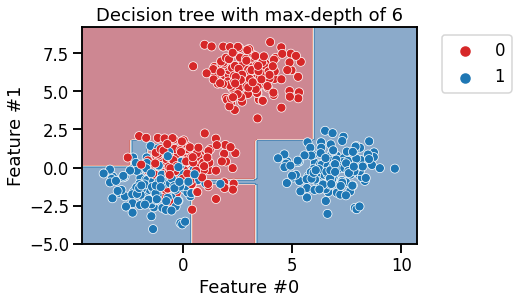

In [23]:
max_depth = 6
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(f"Decision tree with max-depth of {max_depth}")

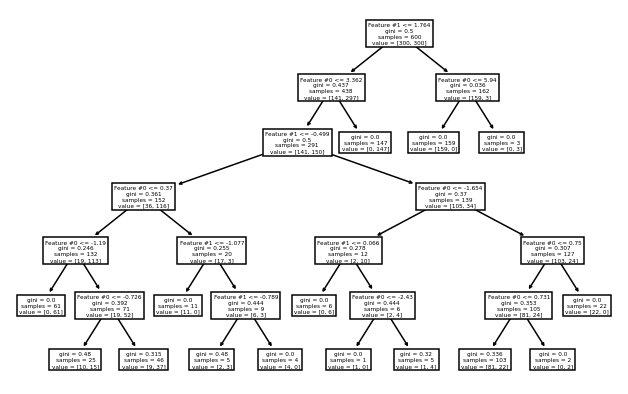

In [24]:
_, ax = plt.subplots(figsize=(11, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

As expected, the left branch of the tree continue to grow while no further
splits were done on the right branch. Fixing the `max_depth` parameter would
cut the tree horizontally at a specific level, whether or not it would
be more beneficial that a branch continue growing.

The hyperparameters `min_samples_leaf`, `min_samples_split`,
`max_leaf_nodes`, or `min_impurity_decrease` allows growing asymmetric trees
and apply a constraint at the leaves or nodes level. We will check the effect
of `min_samples_leaf`.

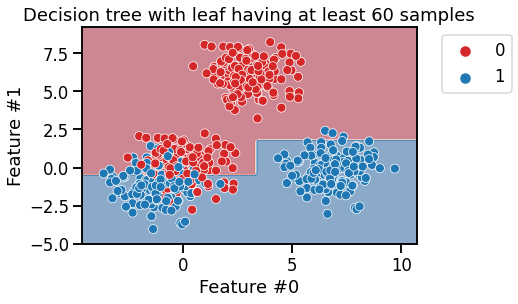

In [25]:
min_samples_leaf = 60
tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column)
_ = plt.title(
    f"Decision tree with leaf having at least {min_samples_leaf} samples")

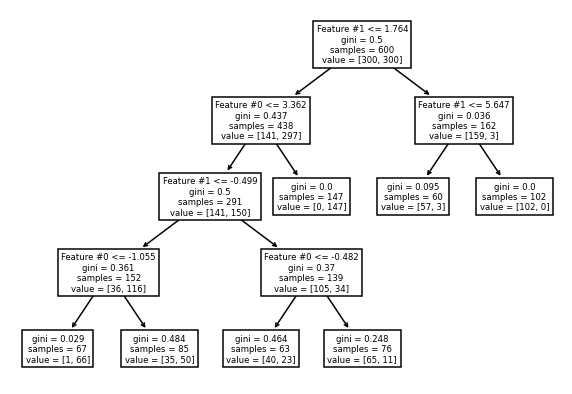

In [26]:
_, ax = plt.subplots(figsize=(10, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

This hyperparameter allows to have leaves with a minimum number of samples
and no further splits will be searched otherwise. Therefore, these
hyperparameters could be an alternative to fix the `max_depth`
hyperparameter.